In [1077]:
import re
from datetime import datetime
import os

# Define the directory path where the files are stored
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

# Function to parse the filename and extract wait time and date-time information
def parse_filename(filename):
    # Updated pattern to match the new filename format
    pattern = r'Ramsey_bussed_qubit_WaitTime(\d+)us_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        wait_time = int(match.group(1))  # Wait time in microseconds
        date_str = match.group(2) + match.group(3)
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')  # Date and time
        return wait_time, date_time
    else:
        return None, None

# Function to extract raw data filenames from the content of a file
def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract the raw data filenames from the last line and convert to a list
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')]

    return raw_data_filenames

# Search for files with the same date-time pattern and create a dictionary of wait times
def search_files_by_datetime(directory, target_date_times):
    wait_time_dict = {}
    
    # Loop over all files in the directory
    for filename in os.listdir(directory):
        # Only process files that match the expected pattern
        if filename.startswith('Ramsey_bussed_qubit_WaitTime'):
            wait_time, date_time = parse_filename(filename)
            # Check if the current file's date-time matches any in the target date-times
            if date_time in target_date_times:
                # Parse the raw data filenames for this file
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                
                # Update the dictionary with wait times and file paths
                if wait_time not in wait_time_dict:
                    wait_time_dict[wait_time] = []
                
                # Append file paths to the list of file paths for this wait time
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_FUA\\'
                raw_data_filepaths = [Z_drive_raw_data + raw_filename for raw_filename in raw_data_filenames]
                wait_time_dict[wait_time].extend(raw_data_filepaths)
    
    return wait_time_dict

# Define the target date-times you're searching for (as a list)
target_date_times = [
    # datetime.strptime('20241007_1602', '%Y%m%d_%H%M'),
    # datetime.strptime('20241007_1555', '%Y%m%d_%H%M'),
    # datetime.strptime('20241007_1523', '%Y%m%d_%H%M'),
    # datetime.strptime('20241007_1508', '%Y%m%d_%H%M'),
    datetime.strptime('20241007_1624', '%Y%m%d_%H%M'),
    datetime.strptime('20241007_1649', '%Y%m%d_%H%M')  # Add more target times as needed
]

# Search for files in the directory that match the target date-times
wait_time_dict = search_files_by_datetime(directory_path, target_date_times)

# Output the results
print("Dictionary of wait times and corresponding raw data file paths:")
for wait_time, file_paths in wait_time_dict.items():
    print(f"Wait time: {wait_time} us")
    for path in file_paths:
        print(f"  {path}")

# Example: Remove a specific wait time from the dictionary (if needed)
# if 50000 in wait_time_dict:
#     del wait_time_dict[50000]


Dictionary of wait times and corresponding raw data file paths:
Wait time: 30000 us
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_520
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_521
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_522
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_523
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_524
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_525
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_526
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_527
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_528
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_529
  Z:\Lab Data\Qudit_Ramsey_raw_data\Raw_data_FUA\qudit_ramsey_scan_dimension3_530
Wait time: 200

In [1079]:
import numpy as np
import json

# Function to calculate the shelving threshold
def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

# Function to process raw data for each wait time
def process_raw_data_files(raw_data_filepaths, Num_points_to_ignore=1):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # print(arrays)
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)
    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        arrays_3d.append(arrays)

    # Convert to numpy array
    bool_array = np.array(arrays_3d) > threshold
    result_matrix = np.full(bool_array.shape, False, dtype=bool)
    # print(bool_array)
    # Process to identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            if true_indices[0].size > 0:
                first_true_index = true_indices[0]
                # print(first_true_index)
                if first_true_index[0] != 0:
                    result_matrix[matrix_index, row_index, first_true_index[0]] = True
    
    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])
    # print(filtered_data_array)
    # Compute ket data by averaging the filtered data
    ket_data = []
    for i in filtered_data_array:
        ket_data.append(np.mean(i, axis=0)[2])
    # print(ket_data)
    return ket_data

# Process all wait times in the dictionary
def process_all_wait_times(wait_time_dict):
    processed_data_dict = {}
    
    for wait_time, raw_data_filepaths in wait_time_dict.items():
        ket_data = process_raw_data_files(raw_data_filepaths)
        processed_data_dict[wait_time] = np.array(ket_data)
    
    return processed_data_dict


processed_data = process_all_wait_times(wait_time_dict)

# Output example
print("Processed Data Dictionary:")
for wait_time, ket_data_list in processed_data.items():
    print(f"Wait Time: {wait_time} us")
    print(f"Ket Data: {ket_data_list}")


Processed Data Dictionary:
Wait Time: 30000 us
Ket Data: [0.83333333 0.83695652 0.84782609 0.875      0.62765957 0.54945055
 0.09375    0.17171717 0.31914894 0.45652174 0.87368421]
Wait Time: 20000 us
Ket Data: [0.38095238 0.19512195 0.03030303 0.16494845 0.33766234 0.60465116
 0.72727273 0.83333333 0.76056338 0.67532468 0.2875    ]
Wait Time: 10000 us
Ket Data: [0.69879518 0.83333333 0.81944444 0.80555556 0.5        0.20930233
 0.07317073 0.04347826 0.23595506 0.2625     0.75641026]
Wait Time: 0 us
Ket Data: [0.26027397 0.5443038  0.80821918 1.         0.84       0.75
 0.44444444 0.17105263 0.01234568 0.11764706 0.20930233]
Wait Time: 40000 us
Ket Data: [0.4893617  0.84615385 0.75862069 0.84       0.66666667 0.50909091
 0.28571429 0.05       0.11320755 0.4137931  0.44927536]
Wait Time: 60000 us
Ket Data: [0.20634921 0.24242424 0.6969697  0.84210526 0.703125   0.73214286
 0.65079365 0.73333333 0.58928571 0.14492754 0.16666667]
Wait Time: 70000 us
Ket Data: [0.51162791 0.45454545 0.3636

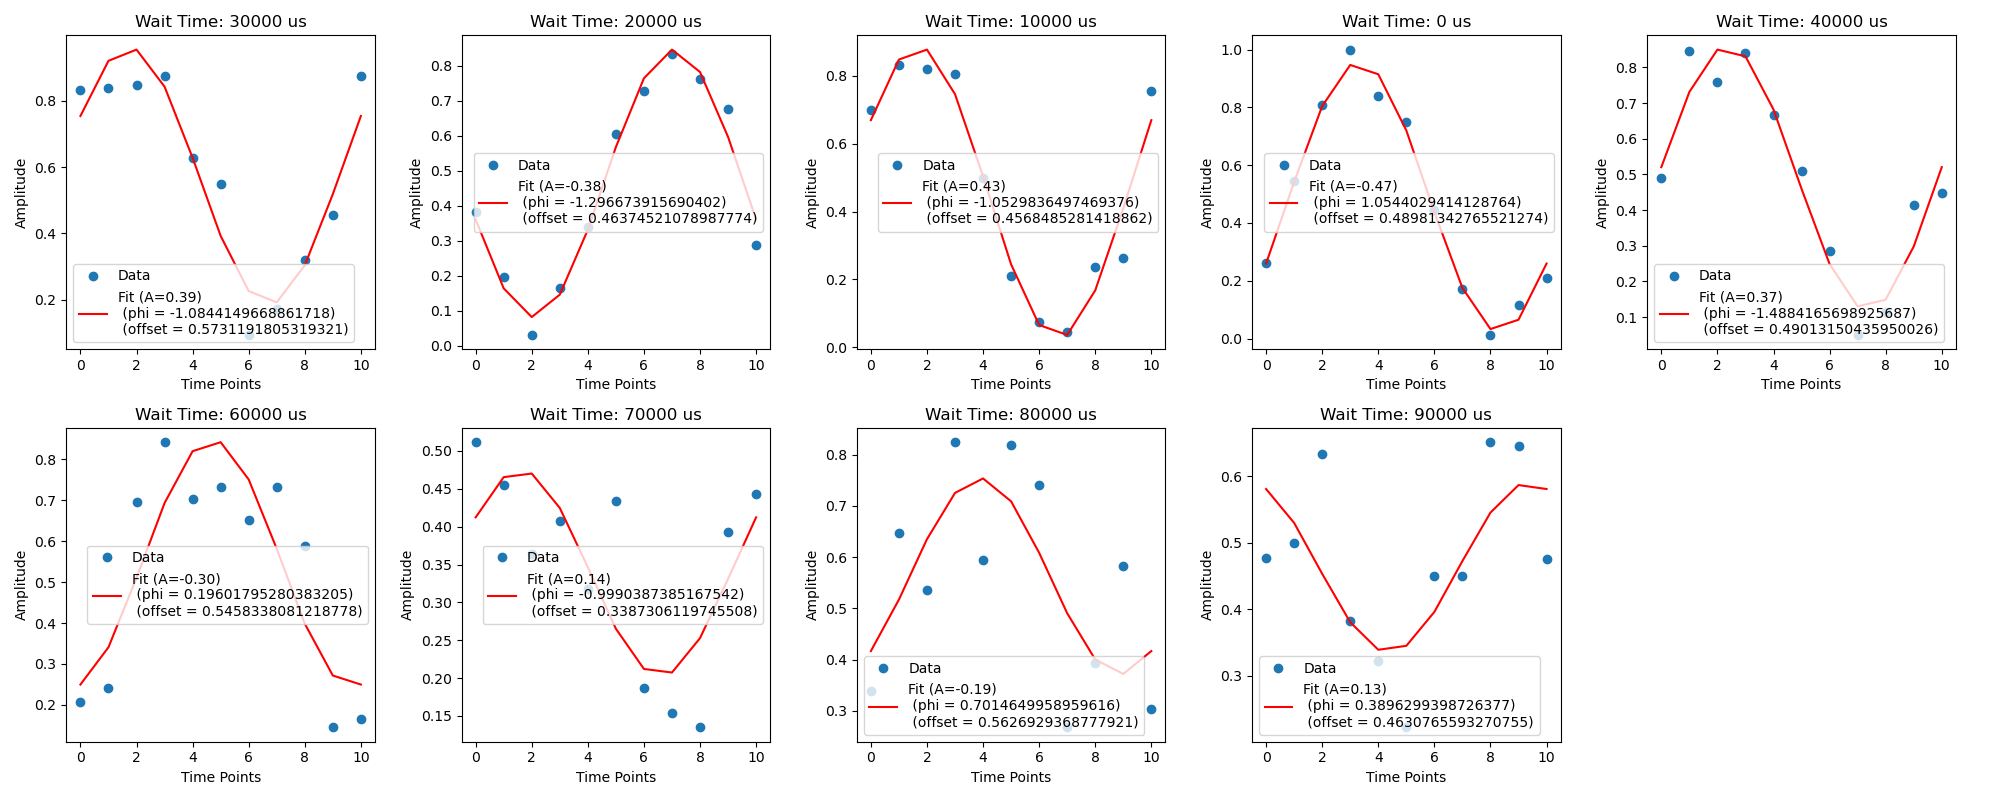

Fitted Amplitudes and Errors:
Wait Time: 30000 us, Amplitude: 0.7733228492679617 ± 0.0914841943583593
Wait Time: 20000 us, Amplitude: 0.7651498915647151 ± 0.0437332930117011
Wait Time: 10000 us, Amplitude: 0.8590691059516083 ± 0.06445775771571921
Wait Time: 0 us, Amplitude: 0.933103818709426 ± 0.038092512874596925
Wait Time: 40000 us, Amplitude: 0.7397938518862359 ± 0.07262333931162539
Wait Time: 60000 us, Amplitude: 0.6036575348330587 ± 0.12614960714452025
Wait Time: 70000 us, Amplitude: 0.2717273990264989 ± 0.08347541542442906
Wait Time: 80000 us, Amplitude: 0.3824609979043179 ± 0.13623665597114779
Wait Time: 90000 us, Amplitude: 0.2551130727102226 ± 0.08773299223708667


In [1081]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine function for fitting: A * sin(omega * t + phi) + offset
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi / 10 * t + phi) + offset

# Function to fit ket_data to sine curve, extract amplitude and errors
def fit_sine_curve(ket_data):
    # Generate a time array for fitting (assuming equal intervals between points)
    t = np.arange(len(ket_data))
    
    # Remove NaN values from both t and ket_data
    valid_indices = ~np.isnan(ket_data)  # Find indices where ket_data is not NaN
    t_valid = t[valid_indices]  # Filter t to keep only valid indices
    ket_data_valid = ket_data[valid_indices]  # Filter ket_data to remove NaNs
    
    # Initial guesses for amplitude (A), angular frequency (omega), phase (phi), and offset
    initial_guess = [1, 0, np.mean(ket_data_valid)]
    
    try:
        # Fit the ket_data to the sine function using only valid data
        params, covariance = curve_fit(sine_function, t_valid, ket_data_valid, p0=initial_guess)
        # print(covariance)
        # Extract standard deviation errors from the covariance matrix
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            # Handle infinite errors by clamping them to None
            errors = [error if np.isfinite(error) else None for error in errors]
        else:
            errors = [None] * len(params)
        
        # Return the parameters of the fit and their errors
        return params, errors
    except RuntimeError:
        # If the fit fails, return None
        return None, None

# Process the entire processed_data dictionary and fit each ket_data to a sine curve
def fit_all_wait_times_to_sine(processed_data_dict):
    fitted_params_dict = {}
    amplitude_dict = {}
    error_dict = {}
    
    for wait_time, ket_data in processed_data_dict.items():
        # Fit the sine curve, skipping NaN values
        params, errors = fit_sine_curve(ket_data)
        if params is not None:
            fitted_params_dict[wait_time] = params
            amplitude_dict[wait_time] = 2 * np.abs(params[0])  # Extract and store amplitude (A)
            error_dict[wait_time] = 2 * np.abs(errors[0]) if errors[0] is not None else None  # Extract and store error of the amplitude
    
    return fitted_params_dict, amplitude_dict, error_dict

# Function to plot the data and fits in a grid with 5 columns
def plot_sine_fits(processed_data_dict, fitted_params_dict):
    num_plots = len(processed_data_dict)
    num_columns = 5
    num_rows = (num_plots + num_columns - 1) // num_columns  # Ensure enough rows for the data
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (wait_time, ket_data) in enumerate(processed_data_dict.items()):
        t = np.arange(len(ket_data))
        ax = axes[i]
        
        # Plot the original data
        ax.plot(t, ket_data, label='Data', marker='o', linestyle='None')
        
        # If there is a fit, plot the sine curve fit
        if wait_time in fitted_params_dict:
            A, phi, offset = fitted_params_dict[wait_time]
            fit_curve = sine_function(t, A, phi, offset)
            ax.plot(t, fit_curve, label=f'Fit (A={A:.2f}) \n (phi = {phi}) \n (offset = {offset})', color='red')
        
        # Set labels and title
        ax.set_title(f'Wait Time: {wait_time} us')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    # Hide unused subplots (in case the number of plots isn't a multiple of 5)
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `processed_data` is your dictionary from the previous step
fitted_params_dict, amplitude_dict, error_dict = fit_all_wait_times_to_sine(processed_data)

# Plot the data and fits
plot_sine_fits(processed_data, fitted_params_dict)

wait_times = []
amplitudes = []
errors = []

# Print the amplitudes and errors dictionary
print("Fitted Amplitudes and Errors:")
for wait_time in amplitude_dict:
    amplitude = amplitude_dict[wait_time]
    error = error_dict[wait_time]
    print(f"Wait Time: {wait_time} us, Amplitude: {amplitude} ± {error}")
    wait_times.append(wait_time)
    amplitudes.append(amplitude)
    errors.append(error)


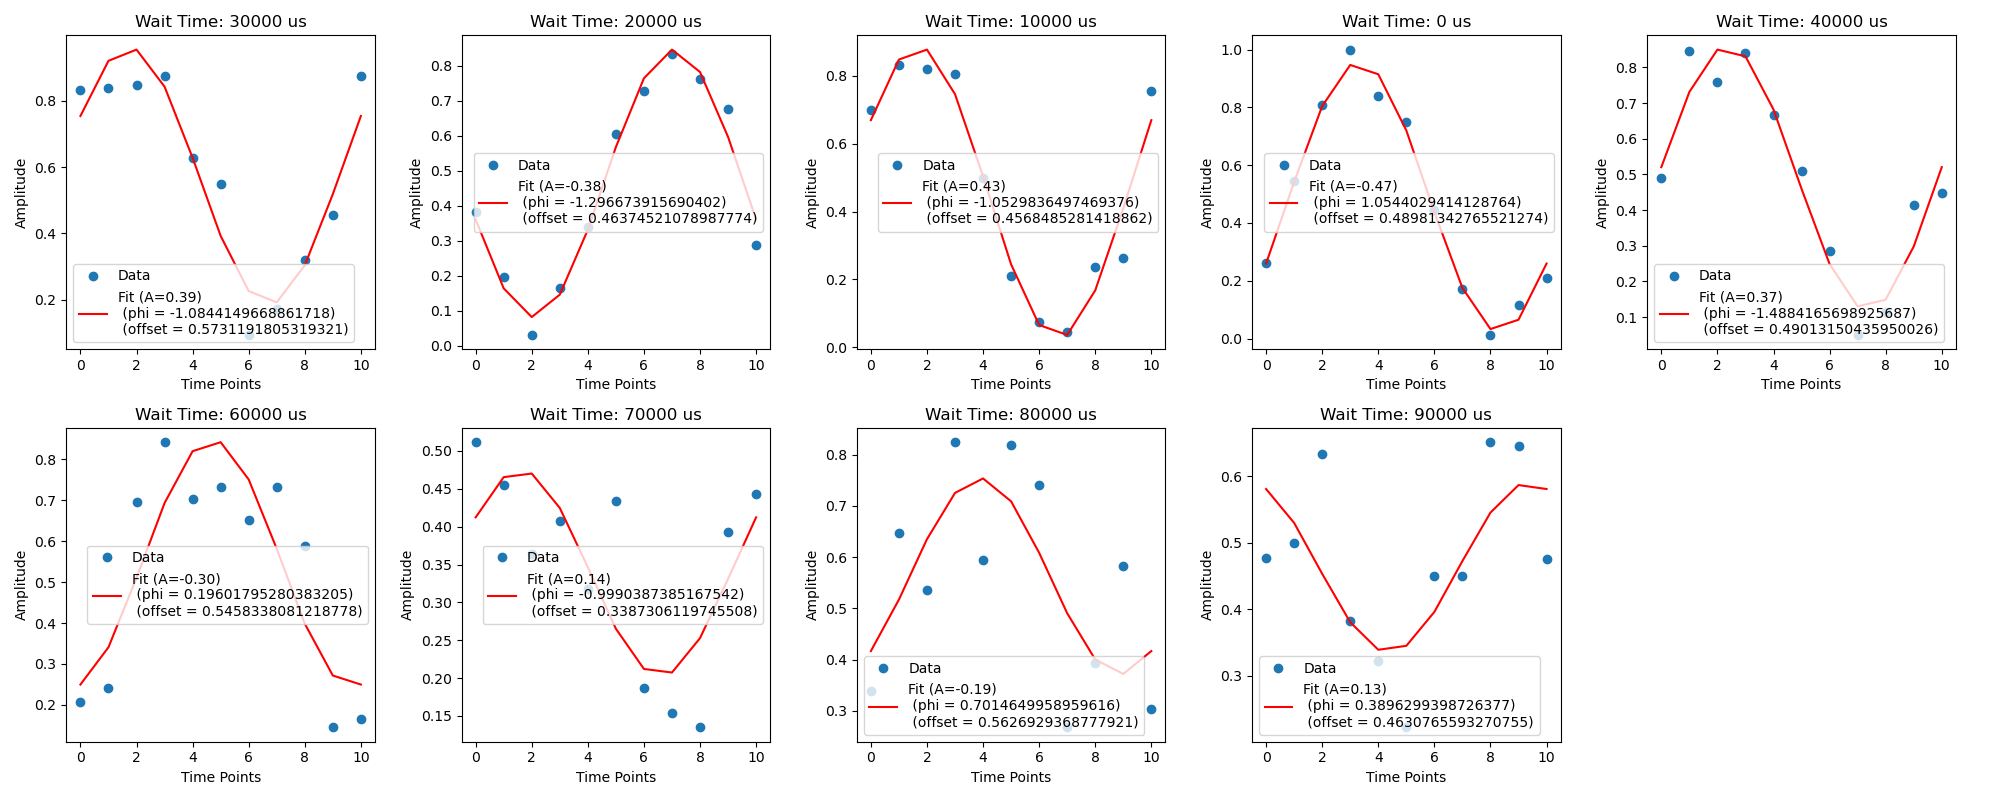

Fitted Amplitudes and Errors:
Wait Time: 30000 us, Amplitude: 0.7733228492679617 ± 0.0914841943583593
Wait Time: 20000 us, Amplitude: 0.7651498915647151 ± 0.0437332930117011
Wait Time: 10000 us, Amplitude: 0.8590691059516083 ± 0.06445775771571921
Wait Time: 0 us, Amplitude: 0.933103818709426 ± 0.038092512874596925
Wait Time: 40000 us, Amplitude: 0.7397938518862359 ± 0.07262333931162539
Wait Time: 60000 us, Amplitude: 0.6036575348330587 ± 0.12614960714452025
Wait Time: 70000 us, Amplitude: 0.2717273990264989 ± 0.08347541542442906
Wait Time: 80000 us, Amplitude: 0.3824609979043179 ± 0.13623665597114779
Wait Time: 90000 us, Amplitude: 0.2551130727102226 ± 0.08773299223708667


In [1083]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine function for fitting: A * sin(omega * t + phi) + offset
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi / 10 * t + phi) + offset

# Function to fit ket_data to sine curve, extract amplitude and errors
def fit_sine_curve(ket_data):
    # Generate a time array for fitting (assuming equal intervals between points)
    t = np.arange(len(ket_data))
    
    # Remove NaN values from both t and ket_data
    valid_indices = ~np.isnan(ket_data)  # Find indices where ket_data is not NaN
    t_valid = t[valid_indices]  # Filter t to keep only valid indices
    ket_data_valid = ket_data[valid_indices]  # Filter ket_data to remove NaNs
    
    # Initial guesses for amplitude (A), angular frequency (omega), phase (phi), and offset
    initial_guess = [1, 0, np.mean(ket_data_valid)]
    
    try:
        # Fit the ket_data to the sine function using only valid data
        params, covariance = curve_fit(sine_function, t_valid, ket_data_valid, p0=initial_guess)
        # Extract standard deviation errors from the covariance matrix
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            # Handle infinite errors by clamping them to None
            errors = [error if np.isfinite(error) else None for error in errors]
        else:
            errors = [None] * len(params)
        
        # Return the parameters of the fit and their errors
        return params, errors
    except RuntimeError:
        # If the fit fails, return None
        return None, None

# Process the entire processed_data dictionary and fit each ket_data to a sine curve
def fit_all_wait_times_to_sine(processed_data_dict):
    fitted_params_dict = {}
    amplitude_dict = {}
    
    for wait_time, ket_data in processed_data_dict.items():
        # Fit the sine curve, skipping NaN values
        params, errors = fit_sine_curve(ket_data)
        if params is not None:
            fitted_params_dict[wait_time] = params
            amplitude = 2 * np.abs(params[0])  # Extract amplitude (A)
            amplitude_error = 2 * np.abs(errors[0]) if errors[0] is not None else None  # Extract error of the amplitude
            amplitude_dict[wait_time] = (amplitude, amplitude_error)  # Store amplitude and error as a tuple
    
    return fitted_params_dict, amplitude_dict

# Function to plot the data and fits in a grid with 5 columns
def plot_sine_fits(processed_data_dict, fitted_params_dict):
    num_plots = len(processed_data_dict)
    num_columns = 5
    num_rows = (num_plots + num_columns - 1) // num_columns  # Ensure enough rows for the data
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (wait_time, ket_data) in enumerate(processed_data_dict.items()):
        t = np.arange(len(ket_data))
        ax = axes[i]
        
        # Plot the original data
        ax.plot(t, ket_data, label='Data', marker='o', linestyle='None')
        
        # If there is a fit, plot the sine curve fit
        if wait_time in fitted_params_dict:
            A, phi, offset = fitted_params_dict[wait_time]
            fit_curve = sine_function(t, A, phi, offset)
            ax.plot(t, fit_curve, label=f'Fit (A={A:.2f}) \n (phi = {phi}) \n (offset = {offset})', color='red')
        
        # Set labels and title
        ax.set_title(f'Wait Time: {wait_time} us')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    # Hide unused subplots (in case the number of plots isn't a multiple of 5)
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `processed_data` is your dictionary from the previous step
fitted_params_dict, amplitude_dict = fit_all_wait_times_to_sine(processed_data)

# Plot the data and fits
plot_sine_fits(processed_data, fitted_params_dict)

wait_times = []
amplitudes = []
errors = []

# Print the amplitudes and errors dictionary
print("Fitted Amplitudes and Errors:")
for wait_time, (amplitude, error) in amplitude_dict.items():
    print(f"Wait Time: {wait_time} us, Amplitude: {amplitude} ± {error}")
    wait_times.append(wait_time)
    amplitudes.append(amplitude)
    errors.append(error)


In [1085]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

# Combined decay model: A * exp(-(t/T2_G)^2) * exp(-t/T2_L)
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

# Fit function with WLS (weighted least squares)
def fit_decay_to_combined_model(wait_times, amplitudes, errors):
    # Ensure initial guesses are scalar values
    print(len(wait_times))
    initial_guess = [
        float(np.max(amplitudes)),       # Starting guess for amplitude
        float(np.mean(wait_times)),      # Starting guess for Gaussian decay
        float(np.mean(wait_times))       # Starting guess for Lorentzian decay
    ]

    try:
        # Use WLS by passing `sigma=errors`
        params, pcov = curve_fit(
            combined_decay,
            wait_times,
            amplitudes,
            p0=initial_guess,
            sigma=errors,  # Apply the weights using the uncertainties
            absolute_sigma=True,  # Ensures the errors are treated as absolute uncertainties
            maxfev=10000
        )
        A, T2_G, T2_L = params
        return A, T2_G, T2_L, pcov
    except RuntimeError:
        return None, None, None, None

# Fit the amplitude data with WLS
def fit_amplitude_decay(amplitude_data, error_data):
    # Extract wait_times, amplitudes, and errors as arrays
    wait_times = np.array(list(amplitude_data.keys()))
    amplitudes = np.array(list(amplitude_data.values()))[:,0]
    errors = np.array(list(error_data.values()))

    # Check shapes
    print('wait_times shape:', wait_times.shape)
    print('amplitudes shape:', amplitudes.shape)
    print('errors shape:', errors.shape)

    # Flatten amplitudes and errors if they are 2D arrays
    if amplitudes.ndim == 2:
        # Flatten amplitudes and errors
        amplitudes_flat = amplitudes.flatten()
        errors_flat = errors.flatten()
        # Repeat wait_times accordingly
        wait_times_flat = np.repeat(wait_times, amplitudes.shape[1])
    elif amplitudes.ndim == 1:
        # Data is already flat
        amplitudes_flat = amplitudes
        errors_flat = errors
        wait_times_flat = wait_times
    else:
        raise ValueError('Amplitudes array has unexpected number of dimensions')

    # Ensure all arrays have the same length
    if len(wait_times_flat) != len(amplitudes_flat) or len(amplitudes_flat) != len(errors_flat):
        raise ValueError("Mismatch in array sizes: wait_times, amplitudes, and errors must have the same length.")

    A, T2_G, T2_L, pcov = fit_decay_to_combined_model(wait_times_flat, amplitudes_flat, errors_flat)

    return A, T2_G, T2_L, pcov

# Calculate the coherence time from T2_G and T2_L
def calculate_coherence_time(T2_G, T2_L):
    # Define the decay function equation to solve for coherence time at 1/e drop
    def decay_eq(t):
        return np.exp(-(t / T2_G)**2 - t / T2_L) - 1 / np.e

    # Use fsolve to find the time where decay equals 1/e
    t_coherence = fsolve(decay_eq, T2_G)  # Initial guess is T2_G
    return t_coherence[0]

# Compute partial derivatives for error propagation
def compute_partial_derivatives(T2_G, T2_L, t_eff):
    t = t_eff
    # Derivatives of the decay equation
    dF_dt = (2 * t) / T2_G**2 + 1 / T2_L
    dF_dT2_G = -2 * t**2 / T2_G**3
    dF_dT2_L = -t / T2_L**2

    # Compute ∂t/∂T2_G and ∂t/∂T2_L
    dt_dT2_G = -dF_dT2_G / dF_dt
    dt_dT2_L = -dF_dT2_L / dF_dt

    return dt_dT2_G, dt_dT2_L

# Example usage with WLS
A, T2_G, T2_L, pcov = fit_amplitude_decay(amplitude_dict, error_dict)

# Output the results if the fit is successful
if all(param is not None for param in [A, T2_G, T2_L, pcov]):
    # Extract standard deviations from the covariance matrix
    sigma_A = np.sqrt(pcov[0, 0])
    sigma_T2_G = np.sqrt(pcov[1, 1])
    sigma_T2_L = np.sqrt(pcov[2, 2])
    cov_T2_G_T2_L = pcov[1, 2]

    print(f"Fitted Coherence Times:")
    print(f"A (Amplitude) = {A} ± {sigma_A}")
    print(f"T2_G (Gaussian) = {T2_G} ± {sigma_T2_G}")
    print(f"T2_L (Lorentzian) = {T2_L} ± {sigma_T2_L}")

    # Calculate effective coherence time
    T2_eff = calculate_coherence_time(T2_G, T2_L)

    # Compute partial derivatives for error propagation
    dt_dT2_G, dt_dT2_L = compute_partial_derivatives(T2_G, T2_L, T2_eff)

    # Calculate the variance of T2_eff
    sigma_T2_eff_squared = (
        (dt_dT2_G**2) * sigma_T2_G**2 +
        (dt_dT2_L**2) * sigma_T2_L**2 +
        2 * dt_dT2_G * dt_dT2_L * cov_T2_G_T2_L
    )
    sigma_T2_eff = np.sqrt(sigma_T2_eff_squared)

    print(f"Effective T2 Time: {T2_eff} ± {sigma_T2_eff}")
else:
    print("Fit failed or not enough data.")


wait_times shape: (9,)
amplitudes shape: (9,)
errors shape: (9,)
9
Fitted Coherence Times:
A (Amplitude) = 0.9210493120581755 ± 0.03622221623381062
T2_G (Gaussian) = 95528.85247647659 ± 25004.515745749122
T2_L (Lorentzian) = 227101.17580997408 ± 189919.63578115668
Effective T2 Time: 77527.02835150744 ± 7247.501220499984


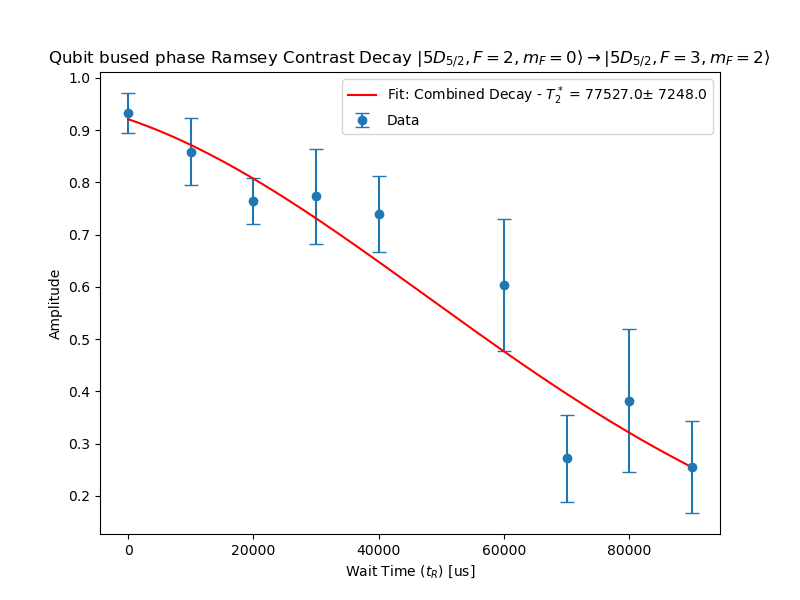

In [1087]:
import numpy as np
import matplotlib.pyplot as plt

# Combined Gaussian and Lorentzian decay function
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G) ** 2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * (gaussian_decay * lorentzian_decay)

# Plot the amplitude data, fit, and error bars
def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff):
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)

    plt.figure(figsize=(8, 6))
    # Plot the amplitude data with error bars
    plt.errorbar(np.array(wait_times), amplitudes, yerr=errors, fmt='o', label='Data', capsize=5)
    
    # Plot the fit curve
    plt.plot(t_fit, amplitude_fit, color='red', label=rf'Fit: Combined Decay - $T_2^*$ = {np.round(T2_eff)}± {np.round(sigma_T2_eff)}')
    
    plt.xlabel('Wait Time ($t_R$) [us]')
    plt.ylabel('Amplitude')
    plt.title(r'Qubit bused phase Ramsey Contrast Decay $|5D_{5/2},F=2,m_F = 0\rangle \rightarrow |5D_{5/2},F=3,m_F = 2\rangle$ ')
    plt.legend()
    
    # Save the figure
    # plt.savefig(f'qubit_phase_ramsey_contrast_decay.png', dpi=300)
    plt.show()

# Example usage assuming the fit was successful
# Replace the following values with actual fit results and data:

plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff)


In [ ]:
%matplotlib widget

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Combined Gaussian and Lorentzian decay function
def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G) ** 2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * (gaussian_decay * lorentzian_decay)

# Plot the amplitude data, fit, and error bars
def plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff):
    t_fit = np.linspace(min(wait_times), max(wait_times), 1000)
    amplitude_fit = combined_decay(t_fit, A, T2_G, T2_L)

    plt.figure(figsize=(8, 6))
    # Plot the amplitude data with error bars
    plt.errorbar(np.array(wait_times), amplitudes, yerr=errors, fmt='o', label='Data', capsize=5)
    
    # Plot the fit curve
    plt.plot(t_fit, amplitude_fit, color='red', label=rf'Fit: Combined Decay - $T_2^*$ = {np.round(T2_eff)}± {np.round(sigma_T2_eff)}')
    
    plt.xlabel('Wait Time ($t_R$) [us]')
    plt.ylabel('Amplitude')
    plt.title(r'Qubit bused phase Ramsey Contrast Decay $|5D_{5/2},F=2,m_F = 0\rangle \rightarrow |5D_{5/2},F=3,m_F = 2\rangle$ ')
    plt.legend()
    
    # Save the figure
    # plt.savefig(f'qubit_phase_ramsey_contrast_decay.png', dpi=300)
    plt.show()

# Example usage assuming the fit was successful
# Replace the following values with actual fit results and data:

plot_fit(wait_times, amplitudes, errors, T2_G, T2_L, A, T2_eff)


NameError: name 'wait_times' is not defined